Problem statement:To build a CNN based model which can accurately detect melanoma. 
Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [143]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Rescaling, InputLayer

In [144]:
# Defining the path for train and test images fromgoogle drive
#root_path='/content/gdrive/MyDrive/CNN/Skin'
#data_dir_train = pathlib.Path(root_path+"/Train")
#data_dir_test = pathlib.Path(root_path+"/Test")

In [145]:
# Importing from local machine
data_dir_train = pathlib.Path("C:/Users/indhumathi.craja/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("C:/Users/indhumathi.craja/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [146]:
#Count number of images present in dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [147]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [148]:
# Splitting train and validation dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [149]:
# Creating validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  label_mode="int",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [150]:
# Listing out all the classes of skin cancer
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [151]:
# Listing out the  train images in each classes
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


In [152]:
# Listing out the  test images in each classes
for i in class_names:
  print(i,": ",len(list(data_dir_test.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  16
basal cell carcinoma :  16
dermatofibroma :  16
melanoma :  16
nevus :  16
pigmented benign keratosis :  16
seborrheic keratosis :  3
squamous cell carcinoma :  16
vascular lesion :  3


**Visualize the data**
   
Visualizing one instance of all the nine classes present in the dataset

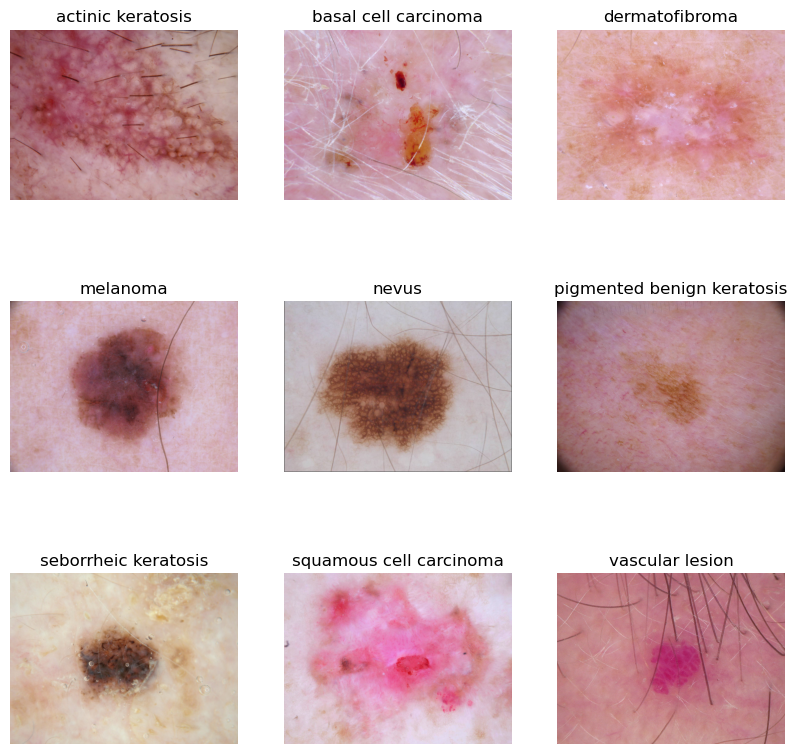

In [153]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for index,images in enumerate(class_names):
  
  temp=plt.imread(list(data_dir_train.glob('{}/*.jpg'.format(images)))[0])
  
  plt.subplot(3,3,index+1)
  plt.imshow(temp)
  plt.axis('off')
  plt.title(images)
  

In [154]:
# Checking shape of image
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [155]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardize the data**

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should  make our input values small.

Standardize values should to be in the [0, 1] range.

In [156]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

**Create the model  (Model 1)**

Creating a CNN model, which can accurately detect 9 classes present in the dataset. 

In [157]:
model=Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(16, 3, activation='relu',padding='same', input_shape = (180, 180, 32)))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, activation='relu',padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation='relu',padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

**Compile the model**

Choosing the following appropirate optimiser and loss function for model training

In [158]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [159]:
# View the summary of all layers
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 45, 45, 64)      

**Train the model**

In [160]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 35s 497ms/step - loss: 1.8754 - accuracy: 0.2913 - val_loss: 1.9324 - val_accuracy: 0.3043
Epoch 2/20
56/56 [==============================] - 24s 436ms/step - loss: 1.5003 - accuracy: 0.4771 - val_loss: 1.4144 - val_accuracy: 0.5235
Epoch 3/20
56/56 [==============================] - 27s 478ms/step - loss: 1.3247 - accuracy: 0.5340 - val_loss: 1.3825 - val_accuracy: 0.5570
Epoch 4/20
56/56 [==============================] - 25s 437ms/step - loss: 1.2101 - accuracy: 0.5826 - val_loss: 1.3977 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 27s 483ms/step - loss: 1.1044 - accuracy: 0.6038 - val_loss: 1.3143 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 30s 538ms/step - loss: 0.9833 - accuracy: 0.6423 - val_loss: 1.3332 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 32s 573ms/step - loss: 0.8934 - accuracy: 0.6730 - val_loss: 1.4090 - val_accuracy: 0.5593

**Visualizing training results**

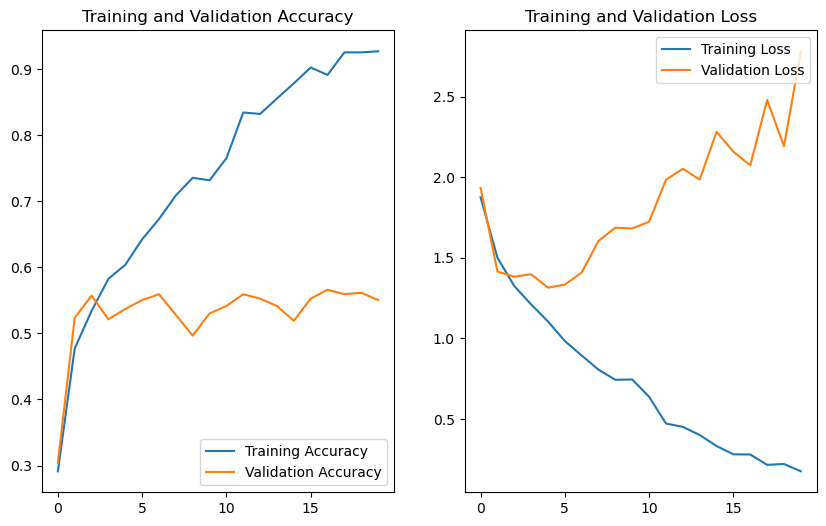

In [161]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Result:

Train Accuracy - 0.92

Train Loss - 0.17

Validation Accuracy - 0.55

Validation Loss - 2.78

Findings:

Clearly by comparing the above results we can say that the model is overfitting as we have high Train Accuracy and Low Validation Accuracy. Also Loss value is higher in validation dataset than train dataset.

Solution:

Need to do some changes in model like  doing data augmentation, including dropout in layers

**Data Augmentation**

Applying Data Augmentation technique like Flip, Rotate, Zoom for input dataset then we can build the model and check for results. 

In [162]:
image_aug = keras.Sequential([layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')])

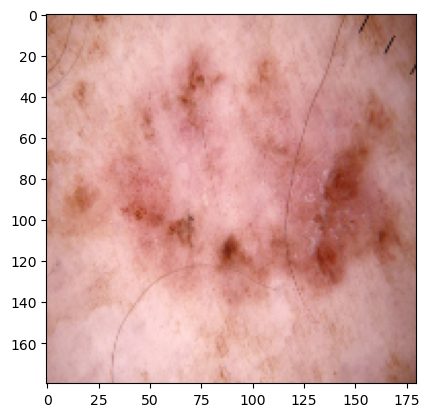

In [163]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_aug1=ImageDataGenerator(rescale=1./255,
                   horizontal_flip=True,
                   zoom_range=0.2)
image_batch,label_batch=next(iter(train_ds))
temp=image_batch[0].numpy()
plt.imshow(temp.astype('uint8'))

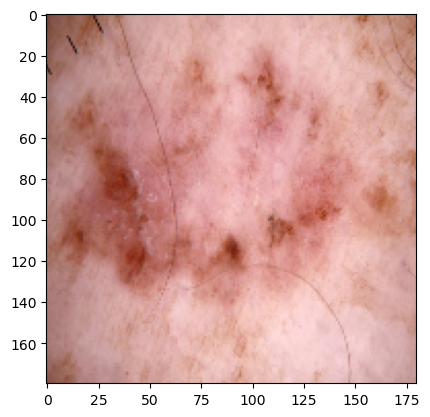

In [164]:
#visualize how your augmentation strategy works for one instance of training image.
plt.imshow(image_aug1.apply_transform(temp,transform_parameters={'flip_horizontal':True}).astype('uint8'))

**Model 2:**

In [165]:
# Create the model
model1=Sequential([image_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model1.add(Conv2D(16, 3, activation='relu',padding='same',input_shape = (180, 180, 32)))
model1.add(MaxPooling2D())

model1.add(Conv2D(32, 3, activation='relu',padding='same'))
model1.add(MaxPooling2D())
model1.add(Conv2D(64, 3, activation='relu',padding='same'))
model1.add(MaxPooling2D())
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(9, activation='softmax'))


In [166]:
# Compile the model
model1.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [167]:
# View the summary of all layers
model1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

In [168]:
# Training the model
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 36s 492ms/step - loss: 2.0686 - accuracy: 0.2266 - val_loss: 1.8937 - val_accuracy: 0.3781
Epoch 2/20
56/56 [==============================] - 25s 445ms/step - loss: 1.7499 - accuracy: 0.3783 - val_loss: 1.7299 - val_accuracy: 0.4139
Epoch 3/20
56/56 [==============================] - 25s 445ms/step - loss: 1.5723 - accuracy: 0.4459 - val_loss: 1.5907 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 25s 442ms/step - loss: 1.4428 - accuracy: 0.4916 - val_loss: 1.4414 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 28s 505ms/step - loss: 1.3899 - accuracy: 0.4994 - val_loss: 1.4958 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 27s 483ms/step - loss: 1.3956 - accuracy: 0.4972 - val_loss: 1.4147 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 26s 472ms/step - loss: 1.3212 - accuracy: 0.5290 - val_loss: 1.4251 - val_accuracy: 0.5168

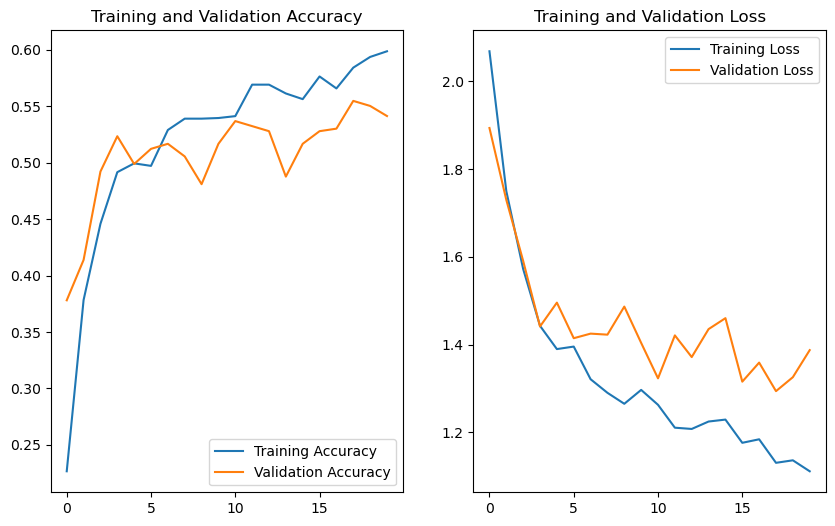

In [169]:
# Visualizing the result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Result:

Training Accuracy - 0.59

Validation Accuracy - 0.54

Training Loss - 1.11

Validation Loss - 1.39

Findings:

From the above results we can see that model is underfitting. Eventhough the Train and validation accuracy is almost near but the value is less. we got only 59% which is not good accuracy. 

Solution:

We can check for class imbalance and rectify using Augmentor package, and can implement batch normalization, dropout in layers. 

**Checking for class imbalance:**

Many datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [170]:
for i in class_names:
  print(i,": ",len(list(data_dir_train.glob('{}/*.jpg'.format(i)))))

actinic keratosis :  114
basal cell carcinoma :  376
dermatofibroma :  95
melanoma :  438
nevus :  357
pigmented benign keratosis :  462
seborrheic keratosis :  77
squamous cell carcinoma :  181
vascular lesion :  139


<BarContainer object of 9 artists>

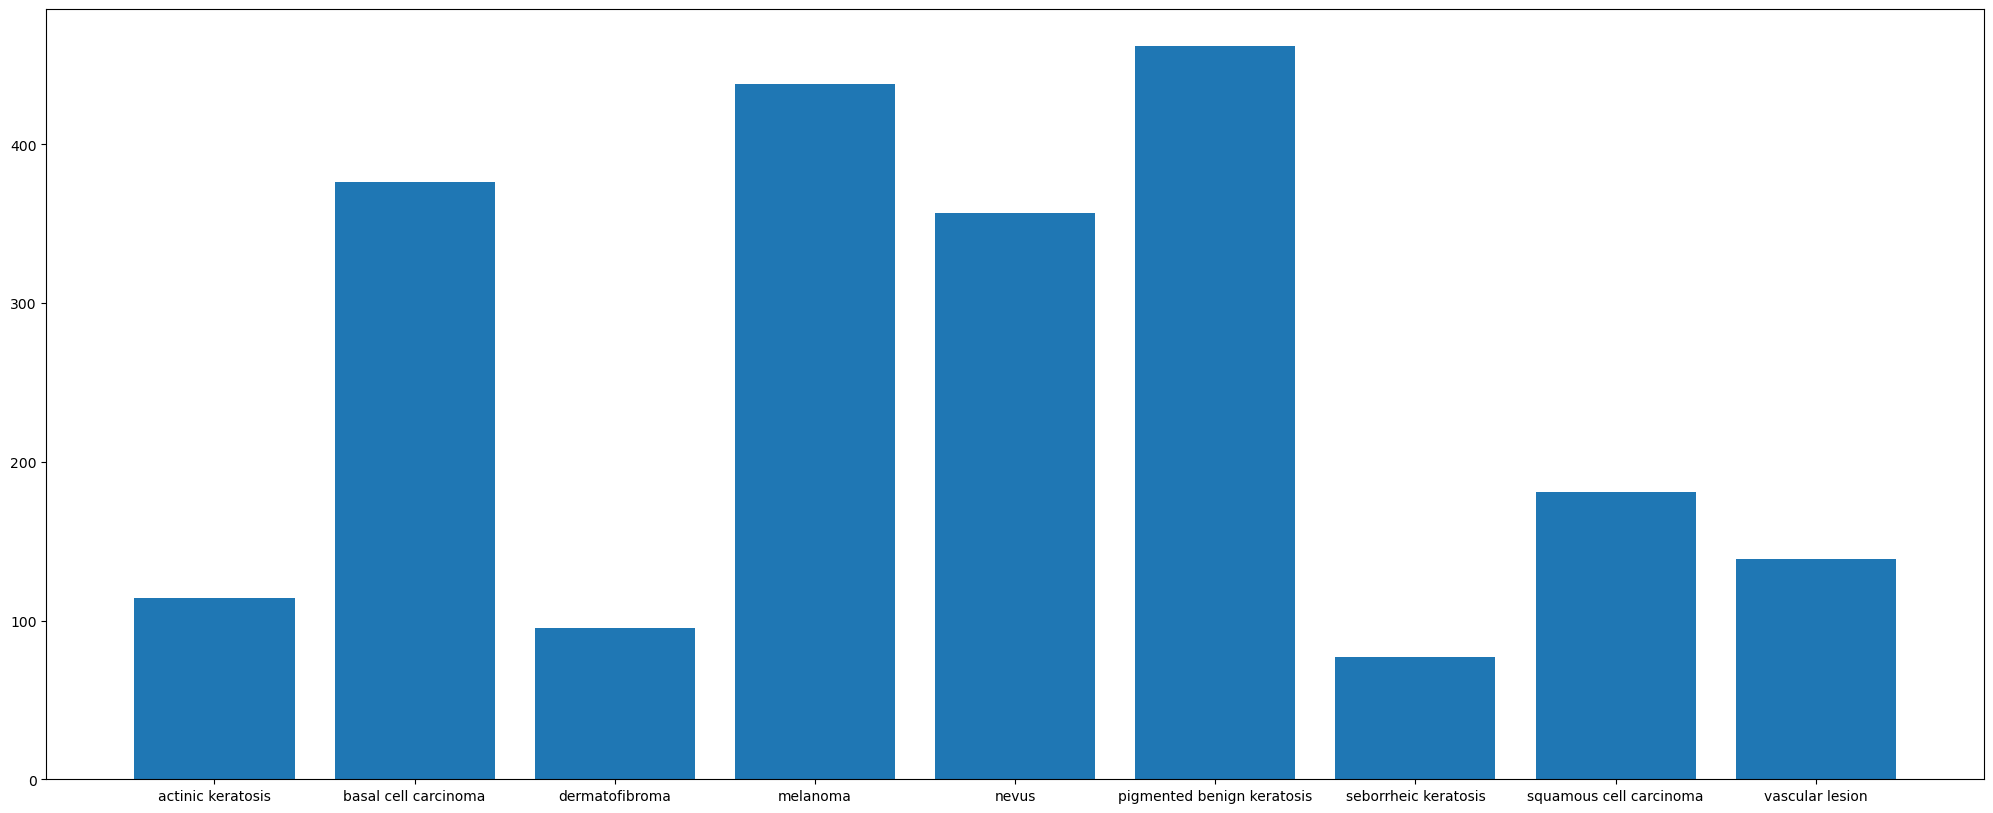

In [171]:
# Visualize class imbalance through chart
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

**'seborrheic keratosis'** has lowest number of image with 77
#### - Which classes dominate the data in terms proportionate number of samples?

**'pigmented benign keratosis'** has more dominent(higher) number of image with 462 

In [172]:
# checking label
path_list=[]
lesion_list=[]
for i in class_names:
      for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,C:\Users\indhumathi.craja\Downloads\CNN_assign...,actinic keratosis
1,C:\Users\indhumathi.craja\Downloads\CNN_assign...,actinic keratosis
2,C:\Users\indhumathi.craja\Downloads\CNN_assign...,actinic keratosis
3,C:\Users\indhumathi.craja\Downloads\CNN_assign...,actinic keratosis
4,C:\Users\indhumathi.craja\Downloads\CNN_assign...,actinic keratosis
...,...,...
2234,C:\Users\indhumathi.craja\Downloads\CNN_assign...,vascular lesion
2235,C:\Users\indhumathi.craja\Downloads\CNN_assign...,vascular lesion
2236,C:\Users\indhumathi.craja\Downloads\CNN_assign...,vascular lesion
2237,C:\Users\indhumathi.craja\Downloads\CNN_assign...,vascular lesion


**Augmentor Package**

A python package known as Augmentor is used to add more samples across all classes so that none of the classes have very few samples.

In [173]:
# Install Augmentor
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [174]:
import Augmentor
for i in class_names:
  augmnt_pipeline = Augmentor.Pipeline(str(data_dir_train) + '/'+ i)
  augmnt_pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  augmnt_pipeline.sample(500)

Initialised with 114 image(s) found.
Output directory set to C:\Users\indhumathi.craja\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2012F1C5D20>: 100%|██████████| 500/500 [00:12<00:00, 38.81 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to C:\Users\indhumathi.craja\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x202D0667D00>: 100%|██████████| 500/500 [00:13<00:00, 36.96 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:\Users\indhumathi.craja\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x202D0680220>: 100%|██████████| 500/500 [00:17<00:00, 29.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to C:\Users\indhumathi.craja\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x201BC5C6470>: 100%|██████████| 500/500 [01:03<00:00,  7.92 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to C:\Users\indhumathi.craja\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x201BC6315D0>: 100%|██████████| 500/500 [00:52<00:00,  9.53 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to C:\Users\indhumathi.craja\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x202D063FA90>: 100%|██████████| 500/500 [00:14<00:00, 34.48 Samples/s]


Initialised with 77 image(s) found.
Output directory set to C:\Users\indhumathi.craja\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x202CCE2CD60>: 100%|██████████| 500/500 [00:30<00:00, 16.32 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Users\indhumathi.craja\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x202CA6748B0>: 100%|██████████| 500/500 [00:15<00:00, 32.14 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:\Users\indhumathi.craja\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x200C3632D70>: 100%|██████████| 500/500 [00:14<00:00, 34.01 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [175]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Checking distribution of augmented data after adding new images to the original training data.**

In [176]:
import os
import glob
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [177]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [178]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [179]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

C:\Users\indhumathi.craja\AppData\Local\Temp\ipykernel_270844\390629722.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [180]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

Now we have added 500 images to all the classes to maintain some class balance.

In [181]:
batch_size = 32
img_height = 180
img_width = 180

**Creating a training dataset**

In [182]:
augmented_data_dir = data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Creating a validation dataset**

In [183]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  augmented_data_dir,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Model 3:**

In [184]:
# Include BatchNormalization, Dropout
model_norm=Sequential()

model_norm.add(InputLayer((180,180,3)))
model_norm.add(Rescaling(1./255))

model_norm.add(Conv2D(32, (3, 3), padding='same'))
model_norm.add(BatchNormalization())
model_norm.add(Activation('relu'))

model_norm.add(MaxPooling2D(pool_size=(2, 2)))

model_norm.add(Conv2D(64, (3, 3)))
model_norm.add(BatchNormalization())
model_norm.add(Activation('relu'))


model_norm.add(MaxPooling2D(pool_size=(2, 2)))
model_norm.add(Dropout(0.25))

model_norm.add(Flatten())
model_norm.add(Dense(512, activation='relu'))
model_norm.add(Dense(256, activation='relu'))
model_norm.add(Dropout(0.25))

model_norm.add(Dense(9, activation='softmax'))


# View the summary of all layers
model_norm.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 180, 180, 32)      128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 88, 88, 64)      

**Compile Model**

In [185]:
#choose an appropirate optimiser and loss function
model_norm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

**Train the model**

In [186]:
epochs = 30
history = model_norm.fit(
  train_ds,
  validation_data=val_ds ,
  epochs=epochs,
)


Epoch 1/30
169/169 [==============================] - 255s 1s/step - loss: 6.9876 - accuracy: 0.2224 - val_loss: 2.1721 - val_accuracy: 0.0950
Epoch 2/30
169/169 [==============================] - 271s 2s/step - loss: 1.8348 - accuracy: 0.2875 - val_loss: 2.3760 - val_accuracy: 0.1537
Epoch 3/30
169/169 [==============================] - 310s 2s/step - loss: 1.7836 - accuracy: 0.3131 - val_loss: 1.6983 - val_accuracy: 0.3437
Epoch 4/30
169/169 [==============================] - 261s 2s/step - loss: 1.6817 - accuracy: 0.3568 - val_loss: 1.6340 - val_accuracy: 0.3883
Epoch 5/30
169/169 [==============================] - 250s 1s/step - loss: 1.5930 - accuracy: 0.3856 - val_loss: 1.5496 - val_accuracy: 0.4068
Epoch 6/30
169/169 [==============================] - 236s 1s/step - loss: 1.5509 - accuracy: 0.3943 - val_loss: 1.5403 - val_accuracy: 0.4165
Epoch 7/30
169/169 [==============================] - 266s 2s/step - loss: 1.4717 - accuracy: 0.4254 - val_loss: 1.3206 - val_accuracy: 0.5019

**Visualizing the result**

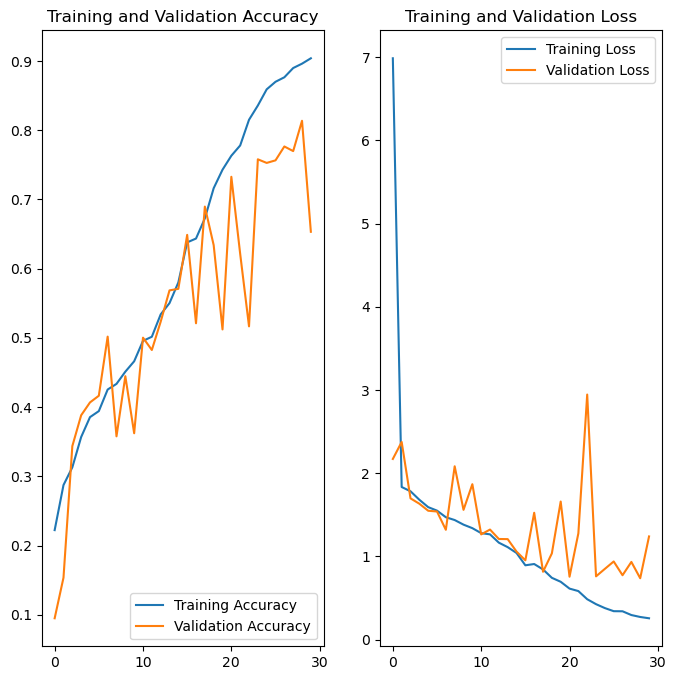

In [187]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Result:

Training Accuracy - 0.90

Validation Accuracy - 0.65

Training Loss - 0.26

Validation Loss - 1.24

Findings:

From the above result we come to know this model's validation accuracy is increased when compared to previous models. But this model is also overfitting.

Using class rebalance, droupout, batch normalization helps in acheiving the better result than simple model.

Solution:

The Model can be further improved by tuning the hyperparameter.

## Conclusion:

We observe improvement from Model 1 to Model 3:

Model 1: Simple CNN Model 

Accuracy: 0.92 | Validation accuracy : 0.55

Model 2: Data Augment with Dropout

Accuracy: 0.59 | Validation accuracy : 0.54

Model 3: Class rebalance,BatchNormalization with Dropout

Accuracy: 0.90 | Validation accuracy : 0.65

Accuracy can be imporved further with proper hyper-parameter. Can use different CNN Configuration, loss function, Optimizers and number of Layers and check how accuracy improves.


